In [1]:
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import math

In [2]:
df = pd.read_csv('CGMData/CGM_with_features.csv')
display(df)

,Readings (CGM / BGM),DateTime,Hour,Minute,Eating,Activity Level,Carbohydrate Intake,Insulin Dosage
0,153,2024-03-05 00:03:00,0,3,No,Low,0,2.0
1,161,2024-03-05 00:08:00,0,8,No,Low,0,2.0
2,171,2024-03-05 00:13:00,0,13,No,Low,0,2.0
3,185,2024-03-05 00:18:00,0,18,No,Low,0,2.0
4,198,2024-03-05 00:23:00,0,23,No,Low,0,2.0
...,...,...,...,...,...,...,...,...
3972,400,2024-03-18 23:36:00,23,36,No,Low,0,2.4
3973,400,2024-03-18 23:41:00,23,41,No,Low,0,2.4
3974,400,2024-03-18 23:46:00,23,46,No,Low,0,2.4
3975,400,2024-03-18 23:51:00,23,51,No,Low,0,2.4


In [3]:
start_date = '2024-03-17'
end_date = '2024-03-18'
recent_data = df[(df['DateTime'] >= start_date) & (df['DateTime'] <= end_date)]

# Prepare the data
X = recent_data[['Hour', 'Minute', 'Eating', 'Activity Level', 'Carbohydrate Intake', 'Insulin Dosage']]
X = pd.get_dummies(X, columns=['Activity Level', 'Eating'], drop_first=True)
y = recent_data['Readings (CGM / BGM)']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the XGBoost model
model = xgb.XGBRegressor()
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
rmse = math.sqrt(mean_squared_error(y_test, y_pred))
print(f'Root Mean Squared Error: {rmse}')

# Assuming 'hour' and 'minute' are columns in your DataFrame
next_hour = recent_data['Hour'].iloc[-1]  # Assuming the last entry in the DataFrame is the latest hour
next_minute = recent_data['Minute'].iloc[-1] + 30  # Adding 30 minutes to the latest minute
if next_minute >= 60:
    next_hour += 1
    next_minute -= 60
next_data_point = [[next_hour, next_minute, 0, 0, 0, 2.4]]  # Replace 0s with actual values for Eating, Activity Level, Carbohydrate Intake, and Insulin Dosage
next_prediction = model.predict(next_data_point)
print(f'Predicted glucose reading for the next 30 minutes: {next_prediction[0]}')

Root Mean Squared Error: 16.8341651188332
Predicted glucose reading for the next 30 minutes: 159.914794921875


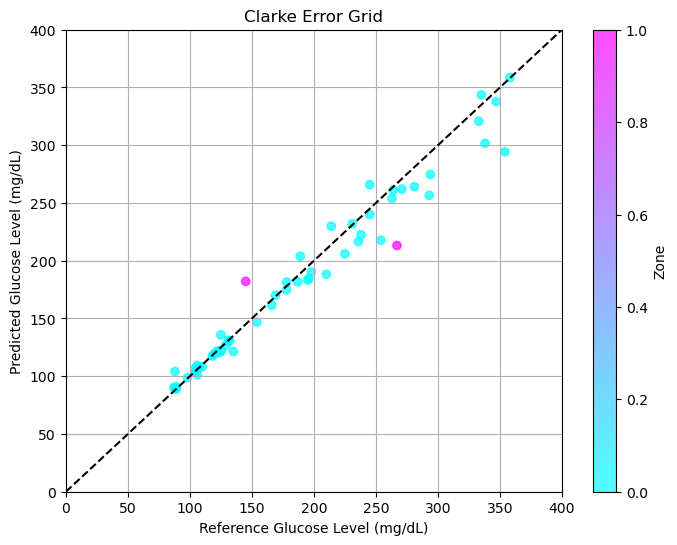

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

percentage_error = abs(y_pred - y_test) / y_test * 100

# Define the Clarke Error Grid zones
def get_zone(error):
    if error < 20:
        return 0
    elif 20 <= error < 40:
        return 1
    elif 40 <= error < 60:
        return 2
    elif 60 <= error < 80:
        return 3
    else:
        return 4

# Categorize the errors into Clarke Error Grid zones
ceg_zones = percentage_error.apply(get_zone)

# Plot the Clarke Error Grid
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, c=ceg_zones, cmap='cool', alpha=0.7)
plt.plot([0, 400], [0, 400], 'k--')  # Line of identity
plt.xlim(0, 400)
plt.ylim(0, 400)
plt.xlabel('Reference Glucose Level (mg/dL)')
plt.ylabel('Predicted Glucose Level (mg/dL)')
plt.title('Clarke Error Grid')
plt.grid(True)
plt.colorbar(label='Zone')
plt.show()